# 02b - Exploratory Data Analysis: Cleaned Data

This notebook performs EDA on the cleaned data to:
- Verify cleaning effectiveness
- Analyze final dataset statistics
- Inform preprocessing decisions (stopwords, min/max length)
- Understand temporal patterns

In [1]:
# Import required libraries
import sys
from pathlib import Path
from collections import Counter
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load cleaned data
settings = get_settings()
data_path = settings.processed_data_dir / settings.clean_metadata_file

print(f"Loading cleaned data from: {data_path}")
df = pd.read_csv(data_path)
print(f"Loaded {len(df):,} records")

Loading cleaned data from: c:\Users\alifn\Code\topic-modeling-utama\data\processed\clean_metadata.csv
Loaded 12,054 records


## 1. Dataset Overview

In [3]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nColumn info:")
df.info()

Dataset Shape: (12054, 10)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12054 entries, 0 to 12053
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   identifier  12054 non-null  object
 1   title       12054 non-null  object
 2   abstract    12054 non-null  object
 3   authors     12054 non-null  object
 4   date        12054 non-null  object
 5   year        12054 non-null  int64 
 6   subjects    12054 non-null  object
 7   publisher   12054 non-null  object
 8   types       12054 non-null  object
 9   language    12054 non-null  object
dtypes: int64(1), object(9)
memory usage: 941.8+ KB


In [4]:
# Verify no critical missing values
print("Missing values check:")
print("-" * 40)
for col in ['title', 'abstract']:
    missing = df[col].isna().sum()
    print(f"{col}: {missing} missing")

if df['title'].isna().sum() == 0 and df['abstract'].isna().sum() == 0:
    print("\n✅ No missing values in critical fields!")

Missing values check:
----------------------------------------
title: 0 missing
abstract: 0 missing

✅ No missing values in critical fields!


In [18]:
# Sample records
df.sample(5)

,identifier,title,abstract,authors,date,year,subjects,publisher,types,language,title_words,abstract_words,abstract_chars,detected_lang
11532,oai:repository.widyatama.ac.id:123456789/3999,ANALISIS FUNGSI TINDAK ILOKUSI DALAM KAITANNYA...,Judul skripsi ini adalah “Analisis Fungsi Tind...,"Vianney, Agustina Ella",2014-11-28T12:44:57Z,2014,Analisis Fungsi Tindak Ilokusi; Prinsip Kesant...,Universitas Widyatama,Thesis,other,20,207,1586,Indonesian
6454,oai:repository.widyatama.ac.id:123456789/5482,MANFAAT AUDIT INTERNAL DALAM MENUNJANG EFEKTIV...,Penjualan merupakan unsur yang memegang perana...,"Radityo HP, F.X",2015-07-01T03:27:06Z,2015,Audit Internal; Pengendalian Internal; Penjualan,Universitas Widyatama,Thesis,other,21,345,2805,Indonesian
10730,oai:repository.widyatama.ac.id:123456789/11596,PENGARUH GOOD CORPORATE GOVERNANCE TERHADAP PR...,Penelitian ini bertujuan untuk (1) mengetahui ...,"Fajriawan, Devara Raditya",2020-11-23T01:31:03Z,2020,"Kepemilikan Institusional, Kepemilikan Manajer...",Program Studi Akuntansi S1 Fakultas Ekonomi - ...,Thesis,Tidak Diketahui,18,139,1145,Indonesian
8354,oai:repository.widyatama.ac.id:123456789/11424,PERENCANAAN BISNIS MEBEL KAYU PINUS WOODWILD D...,Ilmu kewirausahaan adalah suatu disiplin ilmu ...,"Ronal, Nico",2020-11-12T03:46:03Z,2020,"Perencanaan Bisnis, Net Present Value; Plannin...",Program Studi Manajemen S1 Fakultas Ekonomi - ...,Thesis,Tidak Diketahui,9,187,1448,Indonesian
5842,oai:repository.widyatama.ac.id:123456789/2504,TINJAUAN IMPLEMENTASI PERATURAN GUBERNUR JAWA ...,ABSTRAK Dalam penyusunan Laporan Tugas Akhir i...,"Witono, Edi",2014-01-23T02:17:30Z,2014,Peraturan Gubernur Jawa Barat No. 8 Tahun 2012...,Universitas Widyatama,Tidak Diketahui,Tidak Diketahui,24,286,2220,Indonesian


## 2. Text Length Analysis

In [6]:
# Calculate text statistics
df['title_words'] = df['title'].str.split().str.len()
df['abstract_words'] = df['abstract'].str.split().str.len()
df['abstract_chars'] = df['abstract'].str.len()

print("Title word count statistics:")
print(df['title_words'].describe())

print("\nAbstract word count statistics:")
print(df['abstract_words'].describe())

Title word count statistics:
count    12054.000000
mean        17.426497
std          5.885381
min          3.000000
25%         13.000000
50%         17.000000
75%         21.000000
max         49.000000
Name: title_words, dtype: float64

Abstract word count statistics:
count    12054.000000
mean       215.929899
std         77.430612
min         37.000000
25%        160.000000
50%        201.000000
75%        261.000000
max       1700.000000
Name: abstract_words, dtype: float64


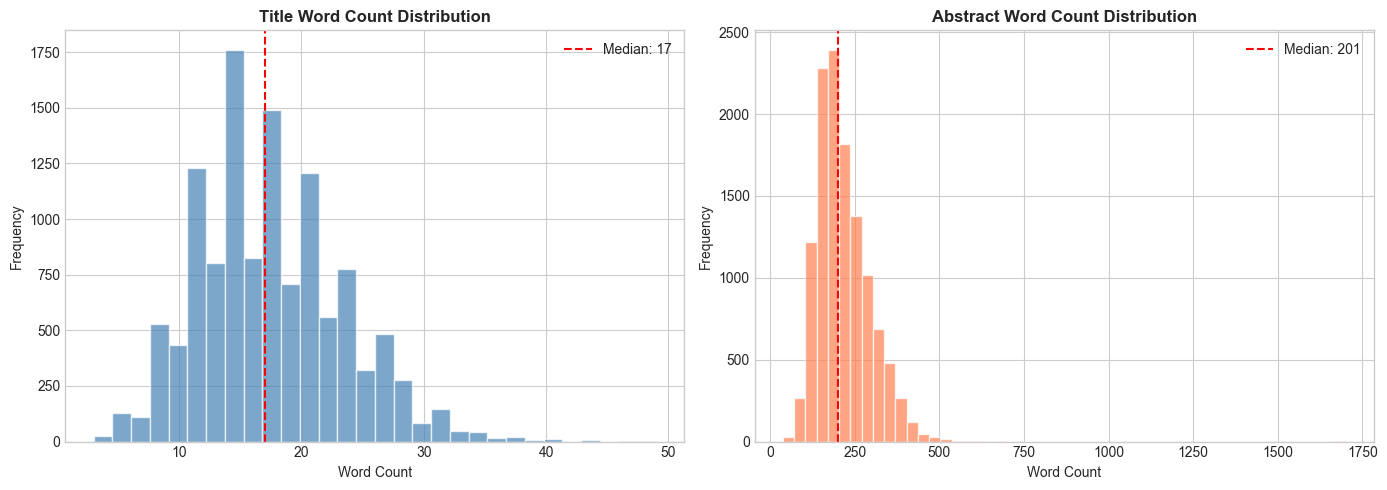

In [7]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title words
axes[0].hist(df['title_words'], bins=30, edgecolor='white', alpha=0.7, color='steelblue')
axes[0].axvline(df['title_words'].median(), color='red', linestyle='--', 
                label=f'Median: {df["title_words"].median():.0f}')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Word Count Distribution', fontweight='bold')
axes[0].legend()

# Abstract words
axes[1].hist(df['abstract_words'], bins=50, edgecolor='white', alpha=0.7, color='coral')
axes[1].axvline(df['abstract_words'].median(), color='red', linestyle='--',
                label=f'Median: {df["abstract_words"].median():.0f}')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Abstract Word Count Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Temporal Analysis

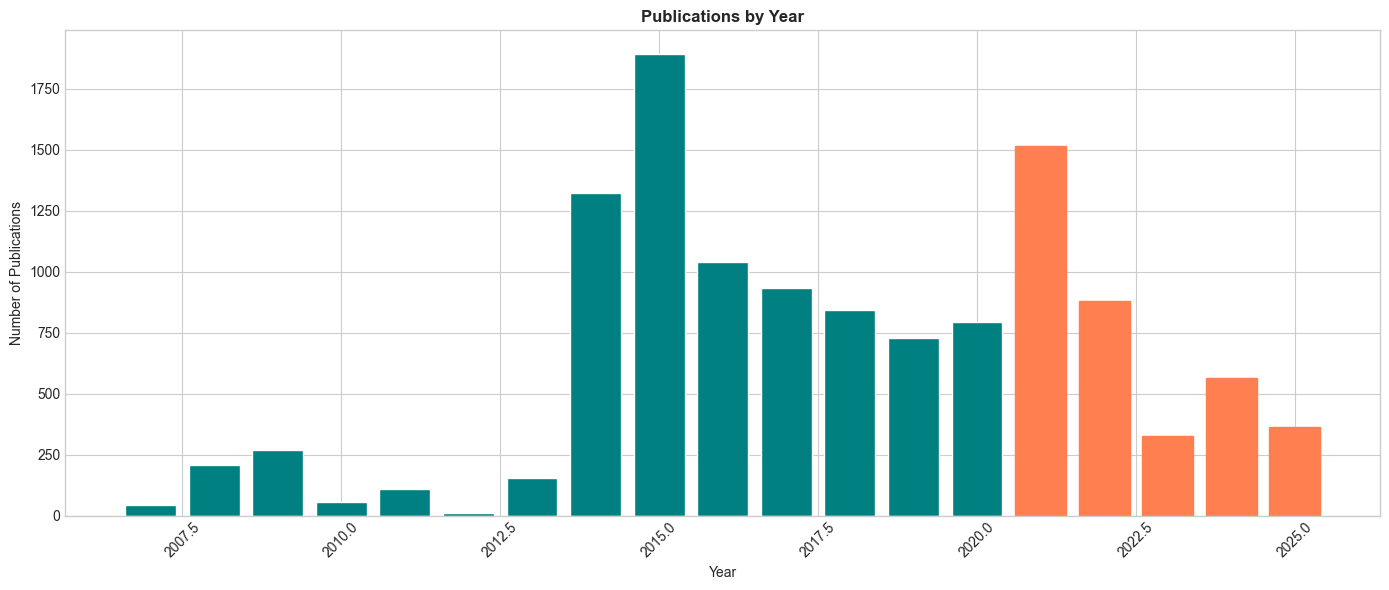


Year range: 2007 - 2025
Most productive year: 2015 (1895 publications)


In [8]:
# Year distribution
if 'year' in df.columns:
    year_counts = df['year'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars = ax.bar(year_counts.index, year_counts.values, edgecolor='white', color='teal')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Publications')
    ax.set_title('Publications by Year', fontweight='bold')
    
    # Highlight recent years
    for bar in bars[-5:]:
        bar.set_color('coral')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nYear range: {df['year'].min():.0f} - {df['year'].max():.0f}")
    print(f"Most productive year: {year_counts.idxmax():.0f} ({year_counts.max()} publications)")

## 4. Word Frequency Analysis (Pre-preprocessing)

In [9]:
# Simple tokenization for frequency analysis
def simple_tokenize(text):
    """Simple tokenization for frequency analysis."""
    if pd.isna(text):
        return []
    text = str(text).lower()
    # Remove punctuation and split
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text)
    return words

# Collect all words from abstracts
all_words = []
for abstract in df['abstract']:
    all_words.extend(simple_tokenize(abstract))

word_counts = Counter(all_words)
print(f"Total words: {len(all_words):,}")
print(f"Unique words: {len(word_counts):,}")

Total words: 2,476,574
Unique words: 36,337


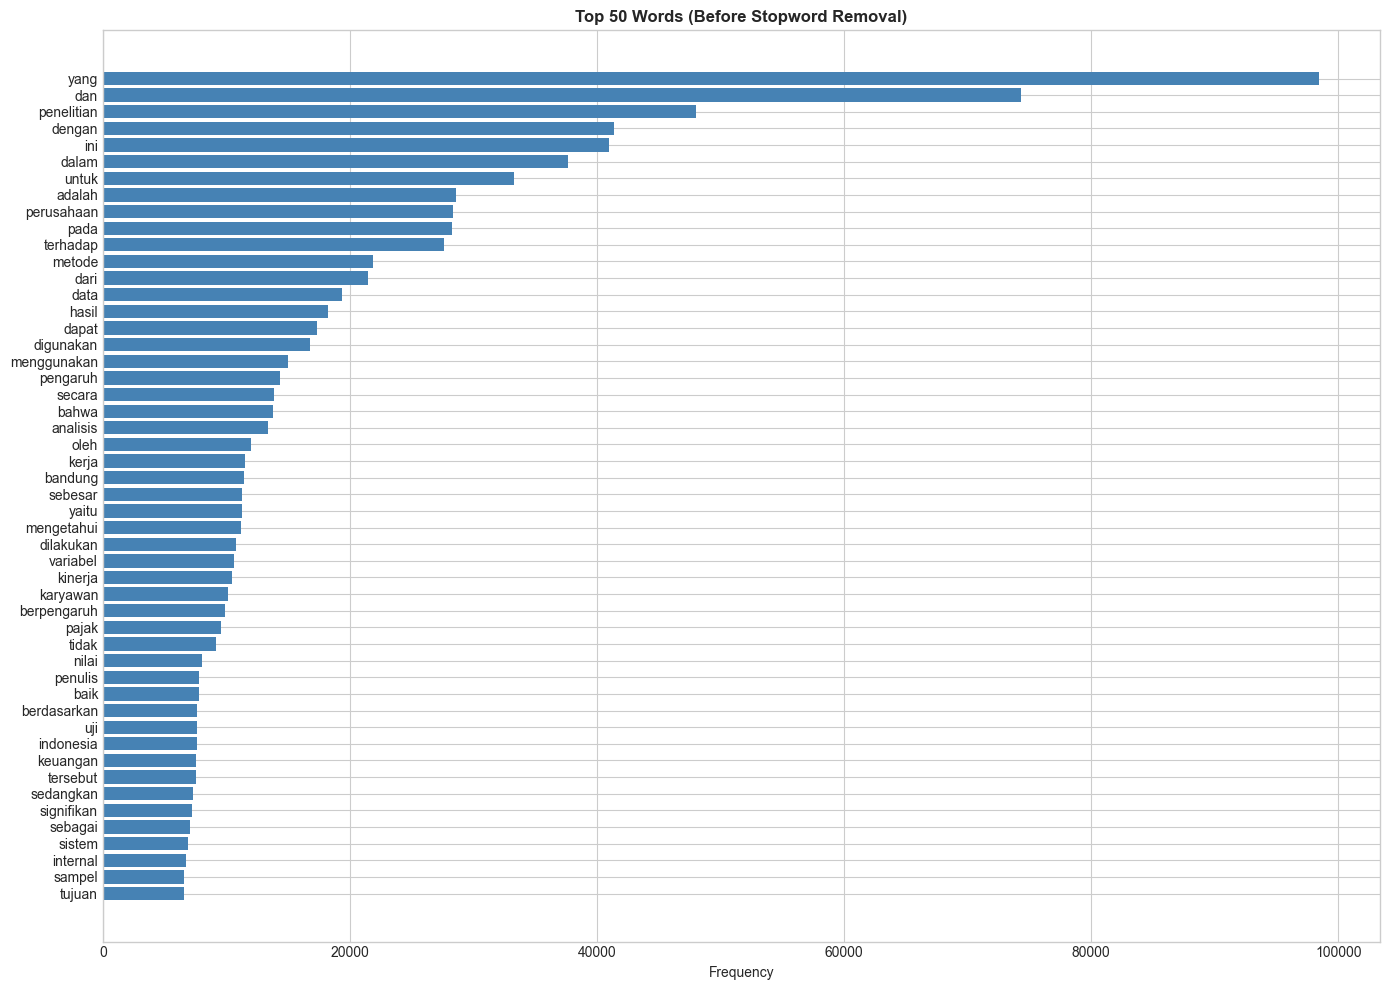

In [10]:
# Top words (many will be stopwords)
top_words = word_counts.most_common(50)

fig, ax = plt.subplots(figsize=(14, 10))
words = [w[0] for w in top_words]
counts = [w[1] for w in top_words]

ax.barh(range(len(words)), counts, color='steelblue')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel('Frequency')
ax.set_title('Top 50 Words (Before Stopword Removal)', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Identify potential stopwords (high frequency, low information)
# These are common Indonesian and English stopwords that appear frequently
common_stopwords = {
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'dengan', 'untuk',
    'pada', 'adalah', 'dalam', 'tidak', 'akan', 'juga', 'atau', 'ada',
    'the', 'and', 'of', 'to', 'in', 'is', 'for', 'on', 'with', 'that',
    'this', 'are', 'as', 'by', 'be', 'an', 'was', 'at', 'or', 'from',
}

# Count stopwords in top 50
top_50_words = set(w[0] for w in top_words)
stopwords_in_top = top_50_words & common_stopwords

print(f"Common stopwords found in top 50: {len(stopwords_in_top)}")
print(f"Words: {sorted(stopwords_in_top)}")

Common stopwords found in top 50: 10
Words: ['adalah', 'dalam', 'dan', 'dari', 'dengan', 'ini', 'pada', 'tidak', 'untuk', 'yang']


## 5. Language Distribution

In [12]:
# Simple language detection
def detect_language(text):
    if pd.isna(text) or text == '':
        return 'unknown'
    
    text_lower = str(text).lower()
    
    id_words = ['yang', 'dan', 'dengan', 'untuk', 'adalah', 'dalam', 'pada', 'dari', 'ini', 'itu']
    en_words = ['the', 'and', 'with', 'for', 'this', 'that', 'from', 'are', 'is', 'of']
    
    id_count = sum(1 for w in id_words if f' {w} ' in f' {text_lower} ')
    en_count = sum(1 for w in en_words if f' {w} ' in f' {text_lower} ')
    
    if id_count > en_count + 2:
        return 'Indonesian'
    elif en_count > id_count + 2:
        return 'English'
    else:
        return 'Mixed/Unknown'

df['detected_lang'] = df['abstract'].apply(detect_language)
lang_dist = df['detected_lang'].value_counts()

print("Language distribution:")
for lang, count in lang_dist.items():
    print(f"  {lang}: {count:,} ({count/len(df)*100:.1f}%)")

Language distribution:
  Indonesian: 11,777 (97.7%)
  English: 269 (2.2%)
  Mixed/Unknown: 8 (0.1%)


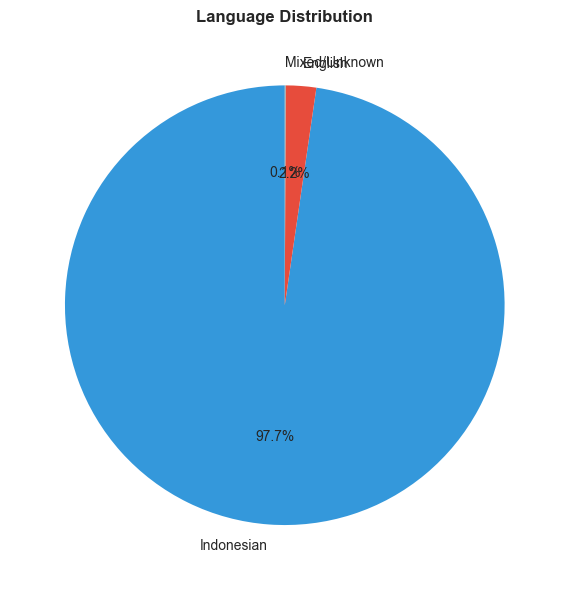

In [13]:
# Visualize language distribution
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#3498db', '#e74c3c', '#95a5a6']
ax.pie(lang_dist.values, labels=lang_dist.index, autopct='%1.1f%%', 
       colors=colors[:len(lang_dist)], startangle=90)
ax.set_title('Language Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Subject Analysis

In [14]:
# Analyze subjects if available
if 'subjects' in df.columns:
    subjects_data = df[df['subjects'].notna() & (df['subjects'] != '')]
    
    all_subjects = []
    for subj_str in subjects_data['subjects']:
        subjects = [s.strip() for s in str(subj_str).split(';') if s.strip()]
        all_subjects.extend(subjects)
    
    subject_counts = Counter(all_subjects)
    
    print(f"Records with subjects: {len(subjects_data):,} ({len(subjects_data)/len(df)*100:.1f}%)")
    print(f"Unique subjects: {len(subject_counts):,}")
    
    # Top subjects
    print("\nTop 15 subjects:")
    for subj, count in subject_counts.most_common(15):
        print(f"  {count:5d}: {subj[:60]}..." if len(subj) > 60 else f"  {count:5d}: {subj}")

Records with subjects: 12,054 (100.0%)
Unique subjects: 17,350

Top 15 subjects:
   1190: Tidak Diketahui
    330: Kinerja Karyawan
    299: Employee Performance
    293: Profitabilitas
    283: Audit Internal
    247: Harga Saham
    234: Profitability
    219: Kualitas Pelayanan
    217: Keputusan Pembelian
    190: Motivasi Kerja
    182: Disiplin Kerja
    178: Motivasi
    175: Motivation
    173: Brand Image
    167: Service Quality


## 7. Preprocessing Recommendations

In [15]:
print("📋 PREPROCESSING RECOMMENDATIONS")
print("=" * 60)

# Language
primary_lang = lang_dist.idxmax()
print(f"\n1. PRIMARY LANGUAGE: {primary_lang}")
print(f"   → Use Indonesian NLP tools (Sastrawi stemmer & stopwords)")
if lang_dist.get('English', 0) > len(df) * 0.1:
    print(f"   → Also include English stopwords (significant English content)")

# Text length
avg_words = df['abstract_words'].mean()
print(f"\n2. DOCUMENT LENGTH:")
print(f"   → Average abstract: {avg_words:.0f} words")
print(f"   → Recommended min_doc_length: 10-20 tokens")

# Vocabulary
print(f"\n3. VOCABULARY:")
print(f"   → Total unique words: {len(word_counts):,}")
print(f"   → Recommended no_below: 5-10 (remove rare words)")
print(f"   → Recommended no_above: 0.5 (remove very common words)")

# Additional
print(f"\n4. ADDITIONAL RECOMMENDATIONS:")
print(f"   → Enable bigram/trigram detection")
print(f"   → Track stemming performance (may be slow)")
print(f"   → Min word length: 3 characters")

print("\n" + "=" * 60)

📋 PREPROCESSING RECOMMENDATIONS

1. PRIMARY LANGUAGE: Indonesian
   → Use Indonesian NLP tools (Sastrawi stemmer & stopwords)

2. DOCUMENT LENGTH:
   → Average abstract: 216 words
   → Recommended min_doc_length: 10-20 tokens

3. VOCABULARY:
   → Total unique words: 36,337
   → Recommended no_below: 5-10 (remove rare words)
   → Recommended no_above: 0.5 (remove very common words)

4. ADDITIONAL RECOMMENDATIONS:
   → Enable bigram/trigram detection
   → Track stemming performance (may be slow)
   → Min word length: 3 characters



In [16]:
# Clean up temporary columns
temp_cols = ['title_words', 'abstract_words', 'abstract_chars', 'detected_lang']
df_clean = df.drop(columns=temp_cols, errors='ignore')

print(f"\n✅ EDA Complete!")
print(f"📊 Dataset ready: {len(df_clean):,} records")
print(f"\n👉 Next: Run 03_preprocessing.ipynb for text preprocessing")


✅ EDA Complete!
📊 Dataset ready: 12,054 records

👉 Next: Run 03_preprocessing.ipynb for text preprocessing
